# Test scipy.signal.correlate on some atl06 data from foundation ice stream

In [1]:
import numpy as np
import scipy, sys, os, pyproj, glob, re, h5py
import matplotlib.pyplot as plt

from scipy.signal import correlate

from astropy.time import Time

%matplotlib notebook
%load_ext autoreload
%autoreload 2

# Test scipy.signal.correlate

Generate some test data:

Text(0.5, 0, 'index')

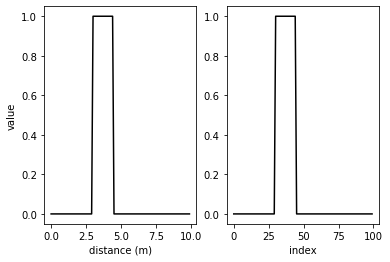

In [2]:
dx = 0.1
x = np.arange(0,10,dx)
y = np.zeros(np.shape(x))
ix0 = 30
ix1 = 30 + 15
y[ix0:ix1] = 1

fig,axs = plt.subplots(1,2)
axs[0].plot(x,y,'k')
axs[0].set_xlabel('distance (m)')
axs[0].set_ylabel('value')
axs[1].plot(np.arange(len(x)), y,'k')
axs[1].set_xlabel('index')

Make a signal to correlate with:

Text(0.5, 0.98, 'black = original, blue = shifted')

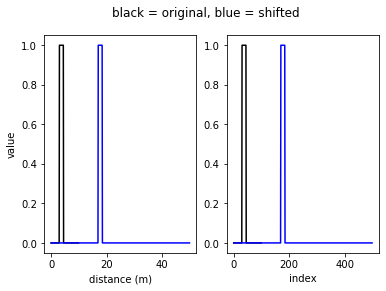

In [3]:
imposed_offset = int(14/dx) # 14 meters, in units of samples

x_noise = np.arange(0,50,dx) # make the vector we're comparing with much longer
y_noise = np.zeros(np.shape(x_noise))
y_noise[ix0 + imposed_offset : ix1 + imposed_offset] = 1

# uncomment the line below to add noise
# y_noise = y_noise * np.random.random(np.shape(y_noise))

fig,axs = plt.subplots(1,2)

axs[0].plot(x,y,'k')
axs[0].set_xlabel('distance (m)')
axs[0].set_ylabel('value')
axs[1].plot(np.arange(len(x)), y, 'k')
axs[1].set_xlabel('index')

axs[0].plot(x_noise,y_noise, 'b')
axs[0].set_xlabel('distance (m)')
axs[0].set_ylabel('value')
axs[1].plot(np.arange(len(x_noise)), y_noise,'b')
axs[1].set_xlabel('index')

fig.suptitle('black = original, blue = shifted')

Try scipy.signal.correlate:

mode ='full' returns the entire cross correlation; could be 'valid' to return only non- zero-padded part

method = direct (not fft)

In [4]:
corr = correlate(y_noise,y, mode = 'full', method = 'direct') 
norm_val = np.sqrt(np.sum(y_noise**2)*np.sum(y**2))
corr = corr / norm_val


What are the dimensions of corr?

In [5]:
print('corr: ', np.shape(corr))
print('x: ', np.shape(x))
print('x: ', np.shape(x_noise))

corr:  (599,)
x:  (100,)
x:  (500,)


Text(0.5, 0.98, 'Shift  140  samples, or  14.0  m to line up signals')

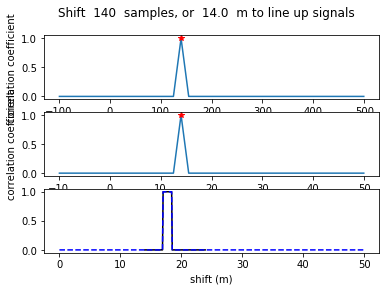

In [6]:
# lagvec = np.arange(0,len(x_noise) - len(x) + 1)
lagvec = np.arange( -(len(x) - 1), len(x_noise), 1)
shift_vec = lagvec * dx

ix_peak = np.arange(len(corr))[corr == np.nanmax(corr)][0]
best_lag = lagvec[ix_peak]
best_shift = shift_vec[ix_peak]

fig,axs = plt.subplots(3,1)

axs[0].plot(lagvec,corr)
axs[0].plot(lagvec[ix_peak],corr[ix_peak], 'r*')
axs[0].set_xlabel('lag (samples)')
axs[0].set_ylabel('correlation coefficient')

axs[1].plot(shift_vec,corr)
axs[1].plot(shift_vec[ix_peak],corr[ix_peak], 'r*')
axs[1].set_xlabel('shift (m)')
axs[1].set_ylabel('correlation coefficient')

axs[2].plot(x + best_shift, y,'k')
axs[2].plot(x_noise, y_noise, 'b--')
axs[2].set_xlabel('shift (m)')


fig.suptitle(' '.join(['Shift ', str(best_lag), ' samples, or ', str(best_shift), ' m to line up signals']))


# Let's try with some ATL06 data

Load some repeat data:


import readers, etc

In [7]:
# ! cd ..; [ -d pointCollection ] || git clone https://www.github.com/smithB/pointCollection.git
# sys.path.append(os.path.join(os.getcwd(), '..'))

# !python3 -m pip install --user git+https://github.com/tsutterley/pointCollection.git@pip
import pointCollection as pc

ModuleNotFoundError: No module named 'pointCollection'

In [8]:
moa_datapath = '/srv/tutorial-data/land_ice_applications/'
datapath = '/home/jovyan/shared/surface_velocity/FIS_ATL06/'


In [9]:
# example hf5 file, if you need to look at the fields
# datapath='/home/jovyan/shared/surface_velocity/FIS_ATL06_small/processed_ATL06_20191129105346_09700511_003_01.h5'
# !h5ls -r /home/jovyan/shared/surface_velocity/FIS_ATL06_small/processed_ATL06_20191129105346_09700511_003_01.h5

# Geographic setting : Foundation Ice Stream

In [10]:
print(pc.__file__)

NameError: name 'pc' is not defined

In [11]:
# something wrong with pointCollection

spatial_extent = np.array([-102, -76, -98, -74.5])
spatial_extent = np.array([-65, -86, -55, -81])


lat=spatial_extent[[1, 3, 3, 1, 1]]
lon=spatial_extent[[2, 2, 0, 0, 2]]
print(lat)
print(lon)
# project the coordinates to Antarctic polar stereographic
xy=np.array(pyproj.Proj(3031)(lon, lat))
# get the bounds of the projected coordinates 
XR=[np.nanmin(xy[0,:]), np.nanmax(xy[0,:])]
YR=[np.nanmin(xy[1,:]), np.nanmax(xy[1,:])]
MOA=pc.grid.data().from_geotif(os.path.join(moa_datapath, 'MOA','moa_2009_1km.tif'), bounds=[XR, YR])

# show the mosaic:
plt.figure()
MOA.show(cmap='gray', clim=[14000, 17000])
plt.plot(xy[0,:], xy[1,:])
plt.title('Mosaic of Antarctica for Pine Island Glacier')

[-86 -81 -81 -86 -86]
[-55 -55 -65 -65 -55]


NameError: name 'pc' is not defined

# Load repeat track data

ATL06 reader

In [12]:
def atl06_to_dict_updated(filename, beam, field_dict=None, index=None, epsg=None):
    """
        Read selected datasets from an ATL06 file

        Input arguments:
            filename: ATl06 file to read
            beam: a string specifying which beam is to be read (ex: gt1l, gt1r, gt2l, etc)
            field_dict: A dictinary describing the fields to be read
                    keys give the group names to be read, 
                    entries are lists of datasets within the groups
            index: which entries in each field to read
            epsg: an EPSG code specifying a projection (see www.epsg.org).  Good choices are:
                for Greenland, 3413 (polar stereographic projection, with Greenland along the Y axis)
                for Antarctica, 3031 (polar stereographic projection, centered on the Pouth Pole)
        Output argument:
            D6: dictionary containing ATL06 data.  Each dataset in 
                dataset_dict has its own entry in D6.  Each dataset 
                in D6 contains a numpy array containing the 
                data
    """
    if field_dict is None:
        field_dict={None:['latitude','longitude','h_li', 'atl06_quality_summary'],\
                    'ground_track':['x_atc','y_atc'],\
                    'fit_statistics':['dh_fit_dx', 'dh_fit_dy']}
    D={}
    # below: file_re = regular expression, it will pull apart the regular expression to get the information from the filename
    file_re=re.compile('ATL06_(?P<date>\d+)_(?P<rgt>\d\d\d\d)(?P<cycle>\d\d)(?P<region>\d\d)_(?P<release>\d\d\d)_(?P<version>\d\d).h5')
    with h5py.File(filename,'r') as h5f:
        for key in field_dict:
            for ds in field_dict[key]:
                if key is not None:
                    ds_name=beam+'/land_ice_segments/'+key+'/'+ds
                else:
                    ds_name=beam+'/land_ice_segments/'+ds
                if index is not None:
                    D[ds]=np.array(h5f[ds_name][index])
                else:
                    D[ds]=np.array(h5f[ds_name])
                if '_FillValue' in h5f[ds_name].attrs:
                    bad_vals=D[ds]==h5f[ds_name].attrs['_FillValue']
                    D[ds]=D[ds].astype(float)
                    D[ds][bad_vals]=np.NaN
        D['data_start_utc'] = h5f['/ancillary_data/data_start_utc'][:]
        D['delta_time'] = h5f['/' + beam + '/land_ice_segments/delta_time'][:]
        D['segment_id'] = h5f['/' + beam + '/land_ice_segments/segment_id'][:]
    if epsg is not None:
        xy=np.array(pyproj.proj.Proj(epsg)(D['longitude'], D['latitude']))
        D['x']=xy[0,:].reshape(D['latitude'].shape)
        D['y']=xy[1,:].reshape(D['latitude'].shape)
    temp=file_re.search(filename)
    D['rgt']=int(temp['rgt'])
    D['cycle']=int(temp['cycle'])
    D['beam']=beam
    return D

Read in files; this next cell took ~1 minute early in the morning

In [13]:
# find all the files in the directory:
# ATL06_files=glob.glob(os.path.join(datapath, 'PIG_ATL06', '*.h5'))
rgt = '0848'
ATL06_files=glob.glob(os.path.join(datapath, '*' + rgt + '*.h5'))

D_dict={}
error_count=0
for file in ATL06_files[:10]:
    try:
        D_dict[file]=atl06_to_dict(file, '/gt2l', index=slice(0, -1, 25), epsg=3031)
    except KeyError as e:
        print(f'file {file} encountered error {e}')
        error_count += 1
print(f"read {len(D_dict)} data files of which {error_count} gave errors")

read 0 data files of which 0 gave errors


Plot ground tracks

NameError: name 'MOA' is not defined

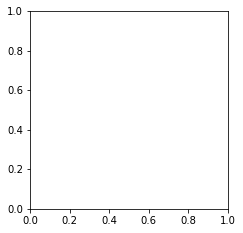

In [14]:
plt.figure(figsize=[8,8])
hax0=plt.gcf().add_subplot(211, aspect='equal')
MOA.show(ax=hax0, cmap='gray', clim=[14000, 17000]);
hax1=plt.gcf().add_subplot(212, aspect='equal', sharex=hax0, sharey=hax0)
MOA.show(ax=hax1, cmap='gray', clim=[14000, 17000]);
for fname, Di in D_dict.items():
    cycle=Di['cycle']
    if cycle <= 2:
        ax=hax0
    else:
        ax=hax1
    #print(fname)
    #print(f'\t{rgt}, {cycle}, {region}')
    ax.plot(Di['x'], Di['y'])
    if True:
        try:
            if cycle  < 3:
                ax.text(Di['x'][0], Di['y'][0], f"rgt={Di['rgt']}, cyc={cycle}", clip_on=True)
            elif cycle==3:
                ax.text(Di['x'][0], Di['y'][0], f"rgt={Di['rgt']}, cyc={cycle}+", clip_on=True)
        except IndexError:
            pass
hax0.set_title('cycles 1 and 2');
hax1.set_title('cycle 3+');

Map view elevations

NameError: name 'ms' is not defined

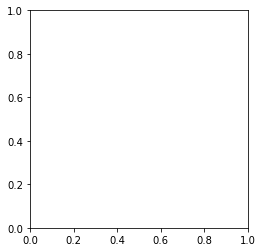

In [15]:
map_fig=plt.figure()
map_ax=map_fig.add_subplot(111)
# MOA.show(ax=map_ax, cmap='gray', clim=[14000, 17000])
for fname, Di in D_dict.items():
    # select elevations with good quality_summary
    good=Di['atl06_quality_summary']==0
    ms=map_ax.scatter( Di['x'][good], Di['y'][good],  2, c=Di['h_li'][good], \
                  vmin=0, vmax=1000, label=fname)
map_ax._aspect='equal'
plt.colorbar(ms, label='elevation');



Repeat track elevation profile

In [16]:
# Ben Smiths's code to plot the individual segments:
def plot_segs(D6, ind=None, **kwargs):
    """
    Plot a sloping line for each ATL06 segment
    """
    if ind is None:
        ind=np.ones_like(D6['h_li'], dtype=bool)
    #define the heights of the segment endpoints.  Leave a row of NaNs so that the endpoints don't get joined
    h_ep=np.zeros([3, D6['h_li'][ind].size])+np.NaN
    h_ep[0, :]=D6['h_li'][ind]-D6['dh_fit_dx'][ind]*20
    h_ep[1, :]=D6['h_li'][ind]+D6['dh_fit_dx'][ind]*20
    # define the x coordinates of the segment endpoints
    x_ep=np.zeros([3,D6['h_li'][ind].size])+np.NaN
    x_ep[0, :]=D6['x_atc'][ind]-20
    x_ep[1, :]=D6['x_atc'][ind]+20

    plt.plot(x_ep.T.ravel(), h_ep.T.ravel(), **kwargs)

In [17]:
# A revised code to plot the elevations of segment midpoints (h_li):
def plot_elevation(D6, ind=None, **kwargs):
    """
    Plot midpoint elevation for each ATL06 segment
    """
    if ind is None:
        ind=np.ones_like(D6['h_li'], dtype=bool)
    # pull out heights of segment midpoints
    h_li = D6['h_li'][ind]
    # pull out along track x coordinates of segment midpoints
    x_atc = D6['x_atc'][ind]

    plt.plot(x_atc, h_li, **kwargs)

No handles with labels found to put in legend.


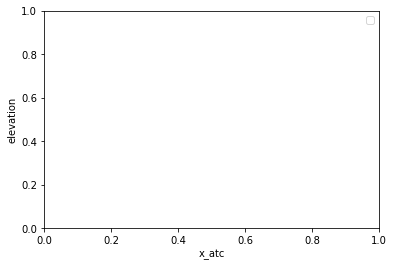

In [18]:
D_2l={}
D_2r={}

# specify the rgt here:
rgt="0027"
rgt="0848" #Ben's suggestion

# iterate over the repeat cycles
for cycle in ['03','04','05','06','07']:
    for filename in glob.glob(os.path.join(datapath, f'*ATL06_*_{rgt}{cycle}*_003*.h5')):
        try:
            # read the left-beam data
            D_2l[filename]=atl06_to_dict(filename,'/gt2l', index=None, epsg=3031)
            # read the right-beam data
            D_2r[filename]=atl06_to_dict(filename,'/gt2r', index=None, epsg=3031)
            # plot the locations in the previous plot
            map_ax.plot(D_2r[filename]['x'], D_2r[filename]['y'],'k');  
            map_ax.plot(D_2l[filename]['x'], D_2l[filename]['y'],'k');
        except Exception as e:
            print(f'filename={filename}, exception={e}')

plt.figure();
for filename, Di in D_2l.items():
    #Plot only points that have ATL06_quality_summary==0 (good points)
    hl=plot_elevation(Di, ind=Di['atl06_quality_summary']==0, label=f"cycle={Di['cycle']}")
    #hl=plt.plot(Di['x_atc'][Di['atl06_quality_summary']==0], Di['h_li'][Di['atl06_quality_summary']==0], '.', label=f"cycle={Di['cycle']}")
    
plt.legend()
plt.xlabel('x_atc')
plt.ylabel('elevation');

Pull out a segment and cross correlate: 

Let's try x_atc = 2.935e7 thru 2.93e7 (just from looking through data)


# Lynn: Test various smoothing window sizes by changing "smoothing_window_size" in this cell and running the cell below. We want to maximize correlation coefficient, and minimize noise. Look for smoothing window sizes that make the data line up nicely in the cell below.

Lynn: Run this cell twice the first time. Still working on figuring out why ... 

In [21]:
cycles = [] # names of cycles with data
for filename, Di in D_2l.items():
    cycles += [str(Di['cycle']).zfill(2)]
cycles.sort()
    
# x1 = 2.93e7
# x2 = 2.935e7

beams = ['gt1l','gt1r','gt2l','gt2r','gt3l','gt3r']

# try and smooth without filling nans
smoothing_window_size = int(np.round(40 / dx)) # meters / dx;
# ex., 60 m smoothing window is a 3 point running average smoothed dataset, because each point is 20 m apart

filt = np.ones(smoothing_window_size)
smoothed = True

### extract and plot data from all available cycles
fig, axs = plt.subplots(4,1)
x_atc = {}
h_li_raw = {}
h_li = {}
h_li_diff = {}
times = {}
for cycle in cycles:
    # find Di that matches cycle:
    Di = {}
    x_atc[cycle] = {}
    h_li_raw[cycle] = {}
    h_li[cycle] = {}
    h_li_diff[cycle] = {}
    times[cycle] = {}

    filenames = glob.glob(os.path.join(datapath, f'*ATL06_*_{rgt}{cycle}*_003*.h5'))
    for filename in filenames:
        try:
            for beam in beams:
                Di[filename]=atl06_to_dict(filename,'/'+ beam, index=None, epsg=3031)

                times[cycle][beam] = Di[filename]['data_start_utc']
                
                # extract h_li and x_atc for that section                
                x_atc_tmp = Di[filename]['x_atc']
                h_li_tmp = Di[filename]['h_li']#[ixs]
                
                # segment ids:
                seg_ids = Di[filename]['segment_id']
#                 print(len(seg_ids), len(x_atcxy=np.array(pyproj.proj.Proj(_tmp))
                
                # make a monotonically increasing x vector
                # assumes dx = 20 exactly, so be carefull referencing back
                ind = seg_ids - np.nanmin(seg_ids) # indices starting at zero, using the segment_id field, so any skipped segment will be kept in correct location
                x_full = np.arange(np.max(ind)+1) * 20 + x_atc_tmp[0]
                h_full = np.zeros(np.max(ind)+1) + np.NaN
                h_full[ind] = h_li_tmp
                
                
                x_atc[cycle][beam] = x_full
                h_li_raw[cycle][beam] = h_full
                              
                # running average smoother /filter
                if smoothed == True:
                    h_smoothed = (1/smoothing_window_size) * np.convolve(filt, h_full, mode = 'same')
                    h_li[cycle][beam] = h_smoothed

    #                 # differentiate that section of data
                    h_diff = (h_smoothed[1:] - h_smoothed[0:-1]) / (x_full[1:] - x_full[0:-1])
                else: 
                    h_li[cycle][beam] = h_full
                    h_diff = (h_full[1:] - h_full[0:-1]) / (x_full[1:] - x_full[0:-1])
                    
                h_li_diff[cycle][beam] = h_diff

                # plot
                
                axs[0].plot(x_full, h_full)
                axs[1].plot(x_full[1:], h_diff)
#                 axs[2].plot(x_atc_tmp[1:] - x_atc_tmp[:-1])
                axs[2].plot(np.isnan(h_full))
                axs[3].plot(seg_ids[1:]- seg_ids[:-1])



        except:
            print(f'filename={filename}, exception={e}')


            

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Lynn: Test "segment_length" in this cell. This is how many meters wide each segment of data we are cross correlating is.

In [22]:
n_veloc = len(cycles) - 1

segment_length = 2000 # m
x1=2.917e7
search_width = 800 # m
dx = 20 # meters between x_atc points

for veloc_number in range(n_veloc):
    cycle1 = cycles[veloc_number]
    cycle2 = cycles[veloc_number+1]
    t1_string = times[cycle1]['gt1l'][0].astype(str) #figure out later if just picking hte first one it ok
    t1 = Time(t1_string)
                       
    t2_string = times[cycle2]['gt1l'][0].astype(str) #figure out later if just picking hte first one it ok
    t2 = Time(t2_string)
    
    dt = (t2 - t1).jd # difference in julian days
        
    velocities = {}     
    for beam in beams:
        fig1, axs = plt.subplots(4,1)
        
        # cut out small chunk of data at time t1 (first cycle)
        x_full_t1 = x_atc[cycle1][beam]
        ix_x1 = np.arange(len(x_full_t1))[x_full_t1 >= x1][0]
        ix_x2 = ix_x1 + int(np.round(segment_length/dx))      
        x_t1 = x_full_t1[ix_x1:ix_x2]
        h_li1 = h_li_diff[cycle1][beam][ix_x1-1:ix_x2-1] # start 1 index earlier because the data are differentiated
        
        # cut out a wider chunk of data at time t2 (second cycle)
        x_full_t2 = x_atc[cycle2][beam]
        ix_x3 = ix_x1 - int(np.round(search_width/dx)) # offset on earlier end by # indices in search_width
        ix_x4 = ix_x2 + int(np.round(search_width/dx)) # offset on later end by # indices in search_width
        x_t2 = x_full_t2[ix_x3:ix_x4]
        h_li2 = h_li_diff[cycle2][beam][ix_x3:ix_x4]

        # plot data
        axs[0].plot(x_t2, h_li2, 'r')
        axs[0].plot(x_t1, h_li1, 'k')
        axs[0].set_xlabel('x_atc (m)')
        
        # correlate old with newer data
        corr = correlate(h_li1, h_li2, mode = 'valid', method = 'direct') 
        
        # normalize correlation function; simplest way (not quite correct)
        # norm_val = np.sqrt(np.sum(h_li1**2)*np.sum(h_li2**2)) # normalize so values range between 0 and 1
        # corr = corr / norm_val

        # a better way to normalize correlation function: shifting along longer vector
        coeff_a_val = np.sum(h_li1**2)
        coeff_b_val = np.zeros(len(h_li2) - len(h_li1)+1)
        for shift in range(len(h_li2) - len(h_li1)+1):
            coeff_b_val[shift] = np.sum(h_li2[shift:shift + len(h_li1)]**2)
        norm_vec = np.sqrt(coeff_a_val * coeff_b_val)
        corr = corr / norm_vec
        
        
#         lagvec = np.arange( -(len(h_li1) - 1), len(h_li2), 1)# for mode = 'full'
#         lagvec = np.arange( -int(search_width/dx) - 1, int(search_width/dx) +1, 1) # for mode = 'valid'
        lagvec = np.arange(- int(np.round(search_width/dx)), int(search_width/dx) +1,1)# for mode = 'valid'

        shift_vec = lagvec * dx

        ix_peak = np.arange(len(corr))[corr == np.nanmax(corr)][0]
        best_lag = lagvec[ix_peak]
        best_shift = shift_vec[ix_peak]
        velocities[beam] = best_shift/(dt/365)

        axs[1].plot(lagvec,corr)
        axs[1].plot(lagvec[ix_peak],corr[ix_peak], 'r*')
        axs[1].set_xlabel('lag (samples)')

        axs[2].plot(shift_vec,corr)
        axs[2].plot(shift_vec[ix_peak],corr[ix_peak], 'r*')
        axs[2].set_xlabel('shift (m)')

        # plot shifted data
        axs[3].plot(x_t2, h_li2, 'r')
        axs[3].plot(x_t1 - best_shift, h_li1, 'k')
        axs[3].set_xlabel('x_atc (m)')
        
        axs[0].text(x_t2[100], 0.6*np.nanmax(h_li2), beam)
        axs[1].text(lagvec[5], 0.6*np.nanmax(corr), 'best lag: ' + str(best_lag) + '; corr val: ' + str(np.round(corr[ix_peak],3)))
        axs[2].text(shift_vec[5], 0.6*np.nanmax(corr), 'best shift: ' + str(best_shift) + ' m'+ '; corr val: ' + str(np.round(corr[ix_peak],3)))
        axs[2].text(shift_vec[5], 0.3*np.nanmax(corr), 'veloc of ' + str(np.round(best_shift/(dt/365),1)) + ' m/yr')

        
    fig1.suptitle('black = older cycle data, red = newer cycle data to search across')


        
        

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [25]:
n_veloc = len(cycles) - 1

segment_length = 2000 # m

search_width = 800 # m
dx = 20 # meters between x_atc points

correlation_threshold = 0.65

x1 = 2.915e7#x_atc[cycles[0]][beams[0]][1000] <-- the very first x value in a file; doesn't work, I think b/c nans # 2.93e7
x1s = x_atc[cycles[veloc_number]][beams[0]][search_width:-segment_length-2*search_width:10]
velocities = {}     
correlations = {}     

for beam in beams:
    velocities[beam] = np.empty_like(x1s)
    correlations[beam] = np.empty_like(x1s)
for xi,x1 in enumerate(x1s):
    for veloc_number in range(n_veloc):
        cycle1 = cycles[veloc_number]
        cycle2 = cycles[veloc_number+1]
        t1_string = times[cycle1]['gt1l'][0].astype(str) #figure out later if just picking hte first one it ok
        t1 = Time(t1_string)

        t2_string = times[cycle2]['gt1l'][0].astype(str) #figure out later if just picking hte first one it ok
        t2 = Time(t2_string)

        dt = (t2 - t1).jd # difference in julian days

        for beam in beams:
            # cut out small chunk of data at time t1 (first cycle)
            x_full_t1 = x_atc[cycle1][beam]
            ix_x1 = np.arange(len(x_full_t1))[x_full_t1 >= x1][0]
            ix_x2 = ix_x1 + int(np.round(segment_length/dx))      
            x_t1 = x_full_t1[ix_x1:ix_x2]
            h_li1 = h_li_diff[cycle1][beam][ix_x1-1:ix_x2-1] # start 1 index earlier because the data are differentiated

            # cut out a wider chunk of data at time t2 (second cycle)
            x_full_t2 = x_atc[cycle2][beam]
            ix_x3 = ix_x1 - int(np.round(search_width/dx)) # offset on earlier end by # indices in search_width
            ix_x4 = ix_x2 + int(np.round(search_width/dx)) # offset on later end by # indices in search_width
            x_t2 = x_full_t2[ix_x3:ix_x4]
            h_li2 = h_li_diff[cycle2][beam][ix_x3:ix_x4]

            # correlate old with newer data
            corr = correlate(h_li1, h_li2, mode = 'valid', method = 'direct') 
            norm_val = np.sqrt(np.sum(h_li1**2)*np.sum(h_li2**2)) # normalize so values range between 0 and 1
            corr = corr / norm_val


    #         lagvec = np.arange( -(len(h_li1) - 1), len(h_li2), 1)# for mode = 'full'
    #         lagvec = np.arange( -int(search_width/dx) - 1, int(search_width/dx) +1, 1) # for mode = 'valid'
            lagvec = np.arange(- int(np.round(search_width/dx)), int(search_width/dx) +1,1)# for mode = 'valid'

            shift_vec = lagvec * dx
            
            if all(np.isnan(corr)):
                velocities[beam][xi] = np.nan
                correlations[beam][xi] = np.nan

            else:
                correlation_value = np.nanmax(corr)
                if correlation_value >= correlation_threshold:
                    ix_peak = np.arange(len(corr))[corr == correlation_value][0]
                    best_lag = lagvec[ix_peak]
                    best_shift = shift_vec[ix_peak]
                    velocities[beam][xi] = best_shift/(dt/365)
                    correlations[beam][xi] = correlation_value

                else:
                    velocities[beam][xi] = np.nan
                    correlations[beam][xi] = correlation_value



In [23]:
plt.figure()
ax1 = plt.subplot(211)
for filename, Di in D_2l.items():
    #Plot only points that have ATL06_quality_summary==0 (good points)
    hl=plot_elevation(Di, ind=Di['atl06_quality_summary']==0, label=f"cycle={Di['cycle']}")
    #hl=plt.plot(Di['x_atc'][Di['atl06_quality_summary']==0], Di['h_li'][Di['atl06_quality_summary']==0], '.', label=f"cycle={Di['cycle']}")
plt.legend()
plt.ylabel('elevation');

ax2 = plt.subplot(212,sharex=ax1)
for beam in beams:
    plt.plot(x1s+dx*(segment_length/2),velocities[beam],'.',alpha=0.2,ms=3,label=beam)
plt.ylabel('velocity (m/yr)')
plt.xlabel('x_atc')
plt.ylim(0,1500)
plt.legend()
plt.suptitle('Along track velocity: all beams')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 0.98, 'Along track velocity: all beams')

In [24]:
plt.figure()
ax1 = plt.subplot(211)
for filename, Di in D_2l.items():
    #Plot only points that have ATL06_quality_summary==0 (good points)
    hl=plot_elevation(Di, ind=Di['atl06_quality_summary']==0, label=f"cycle={Di['cycle']}")
    #hl=plt.plot(Di['x_atc'][Di['atl06_quality_summary']==0], Di['h_li'][Di['atl06_quality_summary']==0], '.', label=f"cycle={Di['cycle']}")
plt.legend()
plt.ylabel('elevation');

ax2 = plt.subplot(212,sharex=ax1)

medians = np.empty(len(x1s))
stds = np.empty(len(x1s))

for xi, x1 in enumerate(x1s):
    corr_vals = []
    velocs = []
    for beam in beams:
        corr_vals += [correlations[beam][xi]]
        velocs += [velocities[beam][xi]]
    n_obs = len(velocs)
    if n_obs >0:
        corr_mask = np.array(corr_vals) >= correlation_threshold
        veloc_mask = np.abs(np.array(velocs)) < 0.67*segment_length # get rid of segments that are nailed against one edge for some reason
        mask = corr_mask * veloc_mask
        median_veloc = np.nanmedian(np.array(velocs)[mask])
        
        std_veloc = np.nanstd(np.array(velocs)[mask])
        medians[xi] = median_veloc
        stds[xi] = std_veloc
        ax2.plot([x1,x1], [median_veloc - std_veloc, median_veloc +std_veloc], '-', color= [0.7, 0.7, 0.7])

ax2.plot(x1s, medians, 'k.', markersize=2)

# for beam in beams:
#     plt.plot(x1s+dx*(segment_length/2),velocities[beam],'.',alpha=0.2,ms=3,label=beam)
plt.ylabel('velocity (m/yr)')
plt.xlabel('x_atc')
plt.ylim(0,1500)
plt.legend()
plt.suptitle('Median along track velocity')

plt.figure()
ax1 = plt.subplot(211)
for beam in beams:
    xvals = x1s+dx*(segment_length/2)
    corrs = correlations[beam]
    ixs = corrs >= correlation_threshold
    ax1.plot(xvals[ixs], corrs[ixs],'.',alpha=0.2,ms=3,label=beam)
plt.ylabel('correlation values, 0->1')
plt.xlabel('x_atc')
plt.legend()
plt.suptitle('Correlation values > threshold, all beams')

ax1 = plt.subplot(212)
for beam in beams:
    ax1.plot(x1s+dx*(segment_length/2),correlations[beam],'.',alpha=0.2,ms=3,label=beam)
plt.ylabel('correlation values, 0->1')
plt.xlabel('x_atc')
plt.legend()
plt.suptitle('Correlation values, all beams')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
No handles with labels found to put in legend.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 0.98, 'Correlation values, all beams')

# Write out the results in a text file

In [25]:
filename = '/home/jovyan/surface_velocity/results_' + rgt + '.txt'
f = open(filename, 'w')

segment_offset = (x1s[10] - x1s[9])

header0 = 'segment_length='+str(segment_length)+',segment_step='+str((segment_offset))+'m,search_width='+str(search_width) + 'm'
header = 'x_atc_segment_middle'
for beam in beams:
    header = header + ',' + beam + '_veloc,' + beam + '_correlationValue'
f.write(header0 + '\n')
f.write(header + '\n')

for xi, x1 in enumerate(x1s):
    x1_middle = np.round(x1 + segment_length/2,3)
    corr_vals = []
    velocs = []
    line = [str(x1_middle)]
    for beam in beams:
        line.append(str(np.round(velocities[beam][xi],2)))
        line.append(str(np.round(correlations[beam][xi],3)))


    line = ','.join(line)
    f.write(line + '\n')
f.close()